<a href="https://colab.research.google.com/github/harshitadd/Celestini/blob/master/Modeltf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install joblib
import tensorflow as tf 
import pickle
from sklearn.externals import joblib
import numpy as np
from tensorflow.python.client import device_lib
from tensorflow.saved_model import simple_save
import random
import matplotlib.pyplot as plt 
import math

from sklearn.model_selection import train_test_split
from tensorflow.python import pywrap_tensorflow


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
# from google.colab import drive
# drive.mount('/content/drive')


In [0]:
#FEATURES AND LABELS  


with open('/content/labelsFinal_withDiffLocations.bin','rb') as file:
  l = pickle.load(file)
  
  
with open('/content/featuresFinal_withDiffLocations.bin','rb') as file:
  temp = pickle.load(file)

In [0]:
features =[]
for i in temp:
  features.append(list(i))

labels=[]  
for i in l:
  labels.append(list(i))

In [0]:
## TEST SET 

x_train_t, x_test_t,y_train_t, y_test_t = train_test_split(features, labels, test_size = 0.3)

In [0]:
tf.reset_default_graph()

In [6]:
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8758674900705394994
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14990615826979900361
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15677045254231540059
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11326753997
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6272483486809704462
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [7]:

from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
model = Sequential()
model.add(Dense(15, input_shape = (9, ), activation = 'relu'))
model.add(Dense(25, activation = 'relu'))
model.add(Dense(1,  activation = 'relu'))

Using TensorFlow backend.
W0814 03:34:01.857945 140568654993280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0814 03:34:01.861228 140568654993280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0814 03:34:01.869518 140568654993280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [8]:
#tf.keras.losses.Huber(delta=0.4)
model.compile(optimizer = Adam(lr = 0.001),loss=tf.keras.losses.Huber(delta=0.4))
model.summary()

W0814 03:34:02.280081 140568654993280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 15)                150       
_________________________________________________________________
dense_2 (Dense)              (None, 25)                400       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 576
Trainable params: 576
Non-trainable params: 0
_________________________________________________________________


In [9]:
hist = model.fit([x_train_t], [y_train_t], validation_split = 0.33, epochs = 1000, verbose = 1, batch_size = 32, shuffle = True)

W0814 03:34:02.476974 140568654993280 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0814 03:34:02.521996 140568654993280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0814 03:34:02.627318 140568654993280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 1158 samples, validate on 571 samples
Epoch 1/1000
1158/1158 [==============================] - 1s 963us/step - loss: 20.8813 - val_loss: 20.6928
Epoch 2/1000
1158/1158 [==============================] - 0s 151us/step - loss: 20.4519 - val_loss: 20.0556
Epoch 3/1000
1158/1158 [==============================] - 0s 147us/step - loss: 19.3939 - val_loss: 18.3821
Epoch 4/1000
1158/1158 [==============================] - 0s 144us/step - loss: 16.9754 - val_loss: 15.0659
Epoch 5/1000
1158/1158 [==============================] - 0s 145us/step - loss: 12.7228 - val_loss: 10.1198
Epoch 6/1000
1158/1158 [==============================] - 0s 165us/step - loss: 8.0999 - val_loss: 7.0874
Epoch 7/1000
1158/1158 [==============================] - 0s 155us/step - loss: 6.9167 - val_loss: 7.0268
Epoch 8/1000
1158/1158 [==============================] - 0s 147us/step - loss: 6.8707 - val_loss: 7.0133
Epoch 9/1000
1158/1158 [==============================] - 0s 145us/step - loss: 6.8462 - val_lo

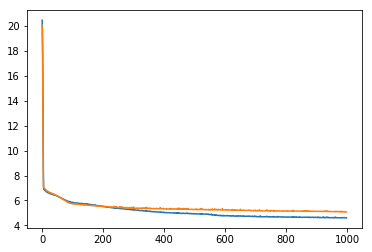

In [10]:
tr = hist.history['loss']
val_ls = hist.history['val_loss']
plt.plot(tr[1:])
plt.plot(val_ls[1:])

In [0]:
predicted = model.predict([x_test_t])


In [0]:
# print(np.shape(y_test_t))
##print(np.shape(predicted))

actual =[]
pred=[]
se=0
show = np.hstack((y_test_t, predicted))

for i in show:
  se+=(i[0]-i[1])**2
  actual.append(i[0])
  pred.append(i[1])
  
 




In [0]:
rmse = (se/np.size(y_test_t))**0.5

In [14]:
print(rmse)

21.77371246379152


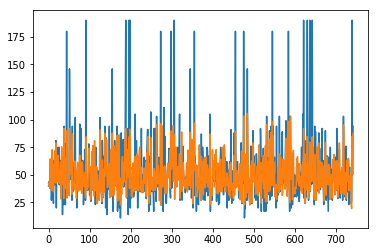

In [15]:
plt.plot(actual)
plt.plot(pred)

In [0]:
print(np.shape(labels))

(2376, 1)


In [0]:
tf.reset_default_graph()

In [0]:
x = tf.placeholder(shape = (None,9), dtype = tf.float32, name = 'input' )
y = tf.placeholder(shape = (None,1), dtype = tf.float32, name = 'target')

#Layer 1 
w1 = tf.Variable((tf.glorot_uniform_initializer(dtype = tf.float32)((9, 15))), name = 'w1')
b1 = tf.Variable((tf.glorot_uniform_initializer(dtype = tf.float32)((1,15))), name = 'b1')

#Layer2 

w2 = tf.Variable((tf.glorot_uniform_initializer(dtype = tf.float32)((15,25))), name = 'w2')
b2 = tf.Variable((tf.glorot_uniform_initializer(dtype = tf.float32)((1,25))), name = 'b2')

#out

wo = tf.Variable((tf.glorot_uniform_initializer(dtype = tf.float32)((25,1))), name = 'wo')
bo = tf.Variable((tf.glorot_uniform_initializer(dtype = tf.float32)((1,1))), name = 'bo')


In [0]:
hidl1 = tf.add(tf.matmul(x,w1),b1, name ='hidden1')
hidl1 = tf.nn.relu(hidl1)
hidl2 = tf.add(tf.matmul(hidl1,w2),b2, name = 'hidden2')
hidl2 = tf.nn.relu(hidl2)

In [0]:
#outl_batch = tf.compat.v1.layers.batch_normalization(hidl2)
out = tf.add(tf.matmul(hidl2,wo),bo,name = 'output')


In [0]:
loss = tf.reduce_mean(tf.square(tf.subtract(y,out))) 

opt = tf.train.AdamOptimizer(name = 'optimizer')
op_train = opt.minimize(loss, name ='train_op')

  

Add additional custom loss functions if necc 
reducing mean sqaure error 
1. reducing max deviation 

In [0]:
saved = tf.train.Saver().as_saver_def()

In [0]:
init = tf.global_variables_initializer()

3474.7205	2506.2266
2443.8784	2695.6594
3801.8132	2414.5303
2821.2021	3232.0066
2383.1982	2464.352
2102.7998	2598.3894
2586.4995	2147.0974
3002.3523	2954.7358
2351.1257	2628.1765
5280.5576	4231.181
3215.914	3146.7988
3813.4775	2294.3438
3456.1375	3204.6924
2720.1062	3663.8818
4361.5293	3347.9783
3936.8943	6134.547
2379.6797	3319.3179
2677.058	2372.8342
3513.546	2755.837
3698.3352	2334.2031
5611.2715	3751.419
3974.5955	3183.9053
2751.5044	3581.887
2972.5254	2999.5205
2992.534	2650.7854
3280.2063	3099.1445
3857.4556	2400.9788
4295.875	2717.588
2410.1816	2661.8809
4625.989	4820.246
2111.6213	3475.069
4145.7314	2119.8347
3945.852	2111.008
4743.9634	4061.2183
2444.772	4174.7407
3114.352	2970.2256
3429.3838	3822.6702
2637.228	2453.0059
3516.8628	2961.3018
3684.2402	6345.6953
2927.671	3567.2039
3136.6895	4469.2344
2480.8445	2911.5588
3592.396	1838.9343
2636.2764	5984.8584
2398.5042	2139.0298
2182.7068	2248.8623
3123.8618	3087.229
3604.1497	3193.9214
5221.132	2388.977
3351.1418	2558.6182
3599.

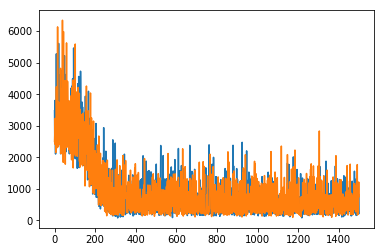

In [0]:

train=[]
val=[]

with tf.device('/device:CPU:0'):
  update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
  save = tf.train.Saver()
  with tf.Session() as sess:
    sess.run(init)
    mini =[]
    for i in range(1500):
      b1=[]
      b2=[]
      l1=[]
      l2=[]
      b1_val=[]
      b2_val=[]
      l1_val=[]
      l2_val=[]
      x_traint, x_test_t,y_traint, y_test_t = train_test_split(features, labels, test_size = 0.3)
      x_trainv, x_testv, y_trainv, y_testv = train_test_split(x_traint, y_traint, test_size = 0.3)
      
      for j in range(16): ##One run is appending 2 random lists 
      
      #TRAINING MINI BATCHES 
        
        seed = random.choice(range(len(x_trainv)))
        i = random.choice(range(len(x_trainv)))
        
        b1.append(x_trainv[seed])
        b2.append(x_trainv[i])
        l1.append(y_trainv[seed])
        l2.append(y_trainv[i])
        
        x_batch = np.vstack((b1,b2))
        y_batch = np.vstack((l1,l2))
        
        ##VALIDATION MINI BATCHES 
        
        seed_val = random.choice(range(len(x_traint)))
        i_val = random.choice(range(len(x_traint)))
        
        b1_val.append(x_traint[seed_val])
        b2_val.append(x_traint[i_val])
        l1_val.append(y_traint[seed_val])
        l2_val.append(y_traint[i_val])
        
        x_batch_val = np.vstack((b1_val,b2_val))
        y_batch_val = np.vstack((l1_val,l2_val))
      
      ## TRAINING LOSS
      update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
      z= sess.run([loss,op_train, update_ops], feed_dict = {x : x_batch, y: y_batch })
      train.append(z[0])
      
      ##VALIDATION LOSS
      
      z_val= sess.run([loss], feed_dict = {x : x_batch_val, y: y_batch_val })
      val.append(z_val[0])
      
      print(str(z[0]) + '\t' + str(z_val[0]))
    
    plt.plot(train)
    plt.plot(val)
    save_path = save.save(sess, "/content/layer2_model.ckpt")
    print('Saved model!')
    
 

In [0]:
print(z)

[705.08997, None, []]


In [0]:
print(type(tf.get_default_graph().as_graph_def()))
tf.io.write_graph(tf.get_default_graph().as_graph_def(), '/content/', '2layer_NN.pbtxt')

<class 'tensorflow.core.framework.graph_pb2.GraphDef'>


'/content/2layer_NN.pbtxt'

In [0]:
with open('/content/2layer_graph.pb', 'wb') as f:
  f.write(tf.get_default_graph().as_graph_def().SerializeToString())
  

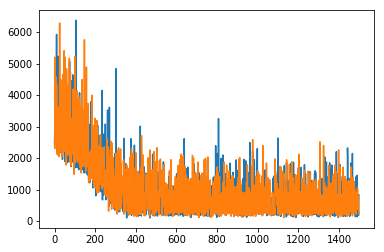

In [0]:
plt.plot(train[1:])
plt.plot(val[1:])

In [0]:
tf.trainable_variables()

[<tf.Variable 'w1:0' shape=(9, 15) dtype=float32_ref>,
 <tf.Variable 'b1:0' shape=(1, 15) dtype=float32_ref>,
 <tf.Variable 'w2:0' shape=(15, 25) dtype=float32_ref>,
 <tf.Variable 'b2:0' shape=(1, 25) dtype=float32_ref>,
 <tf.Variable 'wo:0' shape=(25, 1) dtype=float32_ref>,
 <tf.Variable 'bo:0' shape=(1, 1) dtype=float32_ref>]

In [0]:
## 48 BIT (2253,2315)
'''
features = joblib.load('/content/features48.pkl')
labels = joblib.load('/content/labels48.pkl')
'''

In [0]:
## 16 BIT (2253,267)
'''
features = joblib.load('/content/features16.pkl')
labels = joblib.load('/content/labels16.pkl')
'''